### Setup for the Damped Wave Equation

This block defines physical and numerical parameters for solving the damped wave equation:
$
\frac{\partial^2 u}{\partial t^2} + \eta \frac{\partial u}{\partial t} = c^2 \frac{\partial^2 u}{\partial x^2}
$
We initialize:
- the wave speed $ c $
- the damping ratio $ \zeta $ and compute the damping coefficient $ \eta = 2\zeta\omega $
- a smooth plucked initial condition using the first sine mode

Boundary conditions: Dirichlet (fixed at both ends).

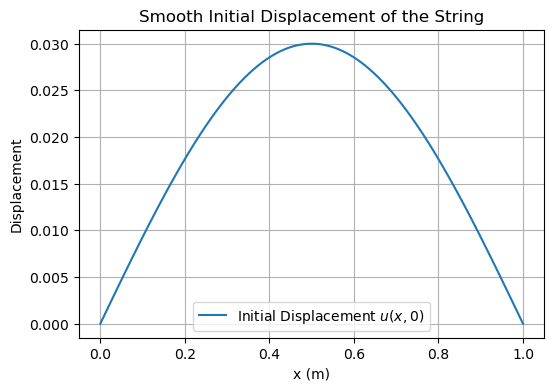

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Physical parameters
L = 1.0                 # Length of the string (meters)
c = 100.0               # Wave speed (m/s)
zeta = 0.01             # Damping ratio (e.g., 1% critical damping)
omega = np.pi * c / L   # First-mode angular frequency
eta = 2 * zeta * omega  # Damping coefficient for PDE

# Numerical parameters
N = 100                 # Number of spatial points
x = np.linspace(0, L, N)
dx = x[1] - x[0]        # Spatial step size

# Initial displacement: smooth pluck using the first sine mode
u0 = 0.03*np.sin(np.pi * x / L)
u0[0] = u0[-1] = 0      # Enforce Dirichlet BCs explicitly

# Initial velocity is zero everywhere
v0 = np.zeros_like(x)

# Plot initial condition
plt.figure(figsize=(6, 4))
plt.plot(x, u0, label="Initial Displacement $u(x, 0)$")
plt.title("Smooth Initial Displacement of the String")
plt.xlabel("x (m)")
plt.ylabel("Displacement")
plt.grid(True)
plt.legend()
plt.show()

### Spatial Discretization for the Damped Wave Equation

This section uses the Method of Lines to define the spatial grid over the domain $ [a, b] $, where the string is fixed at both ends.
- We use $ n = 500 $ uniform subintervals, leading to $ n + 1 $ grid points.
- The grid points are stored in $x$, and the uniform spacing $ dx $ is computed.

This spatial discretization will later be used in the finite difference method to approximate spatial derivatives.

In [2]:
# Domain endpoints
a = 0.0
b = L        # Already defined above as 1.0
n = 500      # Number of subintervals

# Define spatial grid points x_j using a uniform partition
x = np.array([a + (b - a) * (j - 1) / n for j in range(1, n + 2)])

# Recalculate dx from this definition
dx = x[1] - x[0]

# Confirm grid properties
print(f"Number of points: {len(x)}")
print(f"dx = {dx:.5f}")

Number of points: 501
dx = 0.00200


### Visualization of Second-Order Lagrange Basis Polynomials

This section serves only as a visualization of the three second-order Lagrange basis functions centered at a grid point $ x_j $ in the interior of the domain.

- We choose an interior node $ j = n // 2 $ to avoid boundary complications.
- For this node, we evaluate the local Lagrange polynomials $ L_k^{(j)}(x) $, where $ k = 0, 1, 2 $ corresponds to nodes $ x_{j-1}, x_j, x_{j+1} $.
- These basis functions are important in understanding how finite difference and finite element methods approximate derivatives and solutions.

The resulting plot shows the shape and behavior of each basis polynomial over the local neighborhood.

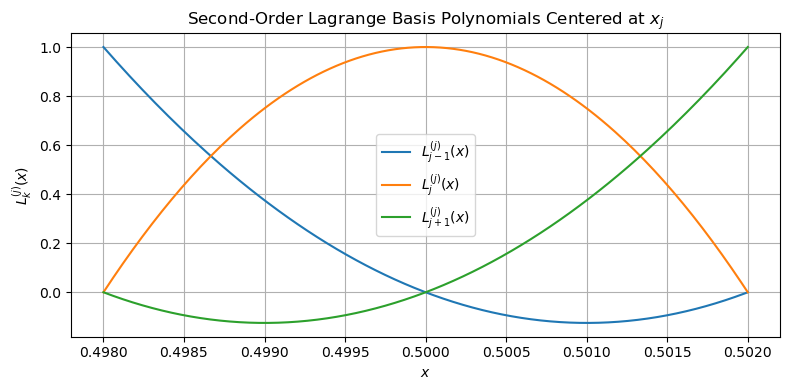

In [3]:
# Choose an interior point j (avoid boundary points)
j = n // 2  # middle of the domain

# Get the three neighboring grid points: x_{j-1}, x_j, x_{j+1}
x_vals = x[j-1:j+2]

# Define Lagrange basis polynomials L_k^{(j)}(x)
def L_k(k, x_eval, x_vals):
    product = 1
    x_k = x_vals[k]
    for m in range(3):
        if m != k:
            product *= (x_eval - x_vals[m]) / (x_k - x_vals[m])
    return product

# Evaluate basis functions over a local fine grid
x_fine = np.linspace(x_vals[0], x_vals[2], 200)
L0 = [L_k(0, xi, x_vals) for xi in x_fine]
L1 = [L_k(1, xi, x_vals) for xi in x_fine]
L2 = [L_k(2, xi, x_vals) for xi in x_fine]

# Plot of Degree-2 Lagrange Basis Polynomials
plt.figure(figsize=(8, 4))
plt.plot(x_fine, L0, label='$L_{j-1}^{(j)}(x)$')
plt.plot(x_fine, L1, label='$L_{j}^{(j)}(x)$')
plt.plot(x_fine, L2, label='$L_{j+1}^{(j)}(x)$')
plt.title('Second-Order Lagrange Basis Polynomials Centered at $x_j$')
plt.xlabel('$x$')
plt.ylabel('$L_k^{(j)}(x)$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Spatial Discretization and Setup for the Damped Wave Equation

This section prepares the spatial grid and operator matrices for solving the **damped wave equation**:

$
\frac{\partial^2 u}{\partial t^2} + 2\gamma \frac{\partial u}{\partial t} = c^2 \frac{\partial^2 u}{\partial x^2},
$

We define:
- The physical domain and wave speed.
- A smooth initial displacement using the first sine mode.
- Zero initial velocity.
- The second derivative matrix `D2` using second-order finite differences.
- Dirichlet boundary conditions enforced on both ends.

The result is a semi-discrete second-order ODE system in time, which will be solved using a suitable time-stepping method that includes damping.

In [4]:
# --- Parameters for Damped Wave Equation ---
L = 1.0                  # Length of the string (meters)
n = 500                  # Number of interior subintervals
c = 1.0                  # Wave speed (m/s)
gamma = 2.0              # Damping coefficient (1/s)
x_a, x_b = 0.0, L        # Domain boundaries
u_a, u_b = 0.0, 0.0      # Dirichlet boundary values

# --- Spatial Discretization ---
x = np.linspace(x_a, x_b, n+2)        # n+2 points including boundaries
dx = x[1] - x[0]                      # Uniform spacing

# --- Initial Conditions ---
u0 = 0.03*np.sin(np.pi * x / L)
u0[0] = u0[-1] = 0  # Enforce Dirichlet BCs
v0 = np.zeros_like(u0)

# --- Finite Difference Laplacian Operator (Second Derivative) ---
D2 = np.zeros((n+2, n+2))
for j in range(1, n+1):
    D2[j, j-1] = 1
    D2[j, j]   = -2
    D2[j, j+1] = 1
D2 *= c**2 / dx**2

# Enforce zero rows for boundary conditions (Dirichlet BCs)
D2[0, :] = D2[-1, :] = 0

# --- Notes ---
# This leads to the semi-discrete system:
#     d²u/dt² + 2γ du/dt = D2 @ u
# which will be solved using the Newmark-beta time-stepping scheme

### Time Integration Using Newmark-Beta Method

This section implements time integration using the Newmark-beta method for the damped wave equation.
The Newmark-beta method is extended to incorporate damping by including the velocity term in the formulation. The parameter choices $\beta = 1/4$, $\gamma = 1/2$ correspond to the unconditionally stable method.

We:
- Initialize displacement, velocity, and acceleration arrays.
- Construct the effective stiffness matrix including the damping contribution.
- Advance the solution through time using the modified Newmark scheme.

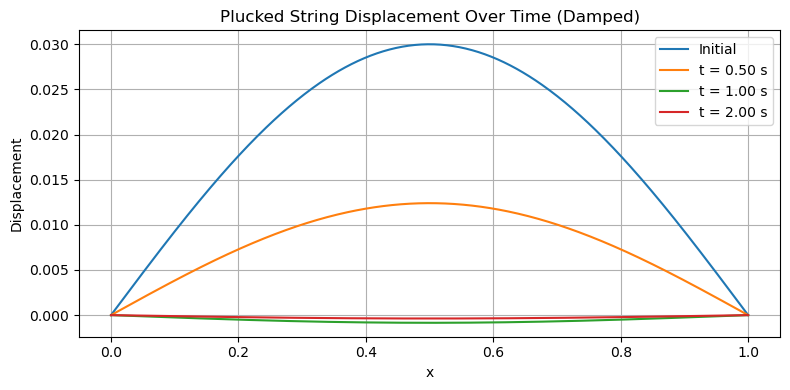

In [5]:
# --- Newmark-beta parameters for damped system ---
beta = 1/4
gamma_beta = 1/2  # avoid name conflict with damping coefficient gamma

# --- Time discretization ---
T = 2.0
dt = 0.00025
Nt = int(T / dt)
time = np.linspace(0, T, Nt+1)

# --- Initialize solution arrays ---
u = np.zeros((Nt+1, n+2))  # Displacement
v = np.zeros((Nt+1, n+2))  # Velocity
a = np.zeros((Nt+1, n+2))  # Acceleration

# --- Initial conditions ---
u[0, :] = u0
v[0, :] = v0
a[0, :] = D2 @ u0 - 2 * gamma * v0  # Modified acceleration: a = u'' = D2 @ u - 2γ v

# --- Effective system matrix for damped wave equation ---
I = np.eye(n+2)
A_eff = I - beta * dt**2 * D2

# --- Time-stepping loop (Newmark-beta with damping) ---
for k in range(Nt):
    # Predict next displacement using modified Newmark update
    rhs = (u[k]
           + dt * v[k]
           + (0.5 - beta) * dt**2 * a[k])

    # Solve for new displacement
    u[k+1] = np.linalg.solve(A_eff, rhs)

    # Compute new acceleration from damped ODE:
    # u'' = D2 @ u - 2γ u'
    a[k+1] = D2 @ u[k+1] - 2 * gamma * v[k]

    # Update velocity
    v[k+1] = (v[k]
              + dt * ((1 - gamma_beta) * a[k] + gamma_beta * a[k+1]))

# --- Plot solution at selected times ---
plt.figure(figsize=(8, 4))
plt.plot(x, u[0], label='Initial')
plt.plot(x, u[Nt//4], label=f't = {time[Nt//4]:.2f} s')
plt.plot(x, u[Nt//2], label=f't = {time[Nt//2]:.2f} s')
plt.plot(x, u[-1], label=f't = {time[-1]:.2f} s')
plt.xlabel('x')
plt.ylabel('Displacement')
plt.title('Plucked String Displacement Over Time (Damped)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Total Mechanical Energy Over Time

We compute the total mechanical energy of the vibrating string at each time step:

- **Kinetic energy**: $ \frac{1}{2} \int_0^L \left( \frac{\partial u}{\partial t} \right)^2 dx \approx \frac{1}{2} \sum_j v_j^2 \, \Delta x $
- **Potential energy**: $ \frac{1}{2} \int_0^L \left( \frac{\partial u}{\partial x} \right)^2 dx \approx \frac{1}{2} \sum_j \left( \frac{u_{j+1} - u_{j-1}}{2 \Delta x} \right)^2 \Delta x $

In the damped case, total energy decays over time.

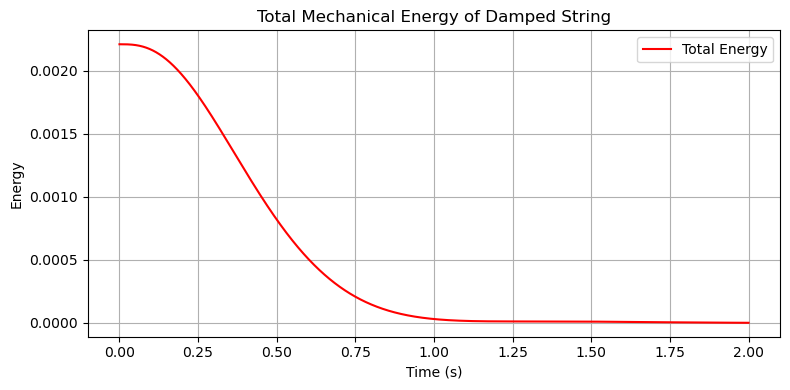

In [6]:
# --- Compute energy over time ---
energy = np.zeros(Nt+1)

for k in range(Nt+1):
    # Kinetic Energy (exclude endpoints)
    KE = 0.5 * np.sum(v[k, 1:-1]**2) * dx

    # Potential Energy via central difference approximation
    du_dx = (u[k, 2:] - u[k, :-2]) / (2 * dx)
    PE = 0.5 * np.sum(du_dx**2) * dx

    # Total mechanical energy
    energy[k] = KE + PE

# --- Plot total energy ---
plt.figure(figsize=(8, 4))
plt.plot(time, energy, label='Total Energy', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('Total Mechanical Energy of Damped String' if gamma > 0 else 'Total Mechanical Energy of Undamped String')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()